#### Libraries


In [2]:
import pandas as pd
import numpy as np
import tqdm as td
import datetime
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


In [2]:
import pyspark
sc = pyspark.SparkContext('local')
sc.setLogLevel('OFF')

In [11]:

import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[1]").appName("SparkByExamples.com").getOrCreate()

### 2. Grouping customers together!

Now we will deal with clustering algorithms that will provide groups of clients which are similar among them.

#### 2.1 Getting your [data](https://www.kaggle.com/datasets/shivamb/bank-customer-segmentation)

First of all we access to data from the link above and import the dataset.

##### A quick pre-processing phase ...

In [21]:
df = pd.read_csv('bank_transactions.csv')

In [22]:
df.isna().sum()

TransactionID                 0
CustomerID                    0
CustomerDOB                3397
CustGender                 1100
CustLocation                151
CustAccountBalance         2369
TransactionDate               0
TransactionTime               0
TransactionAmount (INR)       0
dtype: int64

In [23]:
## Since we have a consistent number of missing values in three columns
## we decide to drop by rows in order to avoid issue during feature engineering.
df.isna().sum()
df.dropna(inplace=True)

In [24]:
df.isna().sum()

TransactionID              0
CustomerID                 0
CustomerDOB                0
CustGender                 0
CustLocation               0
CustAccountBalance         0
TransactionDate            0
TransactionTime            0
TransactionAmount (INR)    0
dtype: int64

In [25]:
## Convert in dollars Balance and Transaction amount with an exchange rate equal to 1:81.67
USD=df['TransactionAmount (INR)'].apply(lambda x:round(x/81.67,2))
df['TransactionAmount_USD']=USD
USD_2=df['CustAccountBalance'].apply(lambda x:round(x/81.67,2))
df['CustAccountBalance_USD']=USD_2
new_df=df.rename(columns={'TransactionAmount (INR)':'TransactionAmount'})

## Transform into datetime object Customer birthday in order to extract features like age from this column
new_df.CustomerDOB = pd.to_datetime(new_df.CustomerDOB) 

In [26]:
## We notice there are some customers born in 1800 
new_df.loc[new_df.CustomerDOB.dt.year == 1800]

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount,TransactionAmount_USD,CustAccountBalance_USD
16,T17,C1376215,1800-01-01,M,MUMBAI,77495.15,1/8/16,124727,1423.11,17.43,948.88
22,T23,C7018081,1800-01-01,M,WAYS PANCHKUVA AHMEDABAD,143.07,3/8/16,104718,110.00,1.35,1.75
28,T29,C7935438,1800-01-01,M,MOHALI,969436.12,3/8/16,183634,36.90,0.45,11870.16
35,T36,C1211387,1800-01-01,M,AHMEDABAD,11791.25,3/8/16,125915,1075.00,13.16,144.38
151,T152,C3334638,1800-01-01,M,PUNE,700.00,9/8/16,24912,1500.00,18.37,8.57
...,...,...,...,...,...,...,...,...,...,...,...
1048443,T1048444,C7261226,1800-01-01,M,BHILAI,1393.33,18/9/16,102427,200.00,2.45,17.06
1048452,T1048453,C3813481,1800-01-01,M,NEW DELHI,984605.24,18/9/16,84644,219.00,2.68,12055.90
1048531,T1048532,C6937679,1800-01-01,M,NEW DELHI,50698.90,18/9/16,184319,598.86,7.33,620.78
1048533,T1048534,C7431884,1800-01-01,M,MANDIR DHANBAD,53771.64,18/9/16,184049,520.00,6.37,658.40


In [27]:
## Drop this customers since we cannot know their real date of birth
new_df.drop(new_df[new_df.CustomerDOB.dt.year == 1800].index, axis=0, inplace=True) 

## Transform TransactionDate column into datetime object in order to extract features like the moth of a transaction or the time
## gap between two transaction
new_df.TransactionDate=pd.to_datetime(new_df.TransactionDate) 

In [28]:
## Transform TransactionDate column into datetime object in order to extract features like average time
new_df.TransactionTime = new_df.TransactionTime.apply(lambda x: datetime.datetime.strptime(str(x).zfill(6), '%H%M%S'))

In [30]:
new_df.loc[new_df.CustomerDOB.dt.year > 2000, 'CustomerDOB']=new_df.loc[new_df.CustomerDOB.dt.year > 2000, 'CustomerDOB']-pd.DateOffset(years = 100)

In [31]:
## From CustomerDOB extract age of each user that make a transaction
new_df['CustomerAge'] = (( pd.to_datetime('today') - new_df.CustomerDOB ) / np.timedelta64(1, 'Y')).round(0).astype(int)

In [33]:
new_df.describe()

,CustAccountBalance,TransactionAmount,TransactionAmount_USD,CustAccountBalance_USD,CustomerAge
count,9.853220e+05,9.853220e+05,985322.000000,9.853220e+05,985322.000000
mean,1.060612e+05,1.452425e+03,17.783707,1.298655e+03,37.535703
std,8.179054e+05,6.139765e+03,75.177806,1.001476e+04,8.984928
min,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,22.000000
25%,4.582132e+03,1.510000e+02,1.850000,5.611000e+01,32.000000
50%,1.600630e+04,4.310000e+02,5.280000,1.959900e+02,35.000000
75%,5.375908e+04,1.125000e+03,13.770000,6.582500e+02,41.000000
max,1.150355e+08,1.560035e+06,19101.690000,1.408540e+06,122.000000


#### Feature engineering

<p>Feature engineering is a process of using domain knowledge to extract features (attributes) from raw data.<br>
Since a CustomerId could have multiple transactions and multiple users, we decide to group transaction by this column.<br>
In fact a CustomerID does not identify a particular user but a credit account which coould be used by multiple users. So for each CustomerId is possible find out that CustomerDOB may change.


In [40]:
dataset=pd.DataFrame()

## The indexes of our  new dataset will be unique values of CustomerID columns
dataset['CustomerID']=new_df.CustomerID.unique()
dataset=dataset.set_index('CustomerID') 

<pr>First of all we create the following features:
1. Number of transactions
2. Number of transactions with a balance bigger than 100 USD
3. Average amount of the transactions
4. Average balance
5. Average difference between the balance and the transaction amount for each customer (this is mainly known in the banking world as utilisation).
6. Most common gender of the customer
7. Most frequent location of the customer

In [41]:
#Number of transactions
new_df.groupby(['CustomerID'],sort=False)['TransactionID'].count()
dataset['Number_Transactions']=new_df.groupby(['CustomerID'],sort=False).count()['TransactionID']

In [42]:
#Number of transactions with a balance bigger than 100 USD

def condition(x):
    if x>100:
        return int(1)
    else:
        return 0

new_df['TransactionAmount_USD>100']=new_df['TransactionAmount_USD'].apply((condition)).to_numpy()
a=new_df.groupby('CustomerID',sort=False)['TransactionAmount_USD>100'].sum()
dataset['Transactions>100']=a

In [43]:
# Average amount of the transactions on USD column
new_df.groupby('CustomerID',sort=False)['TransactionAmount_USD'].mean()
dataset['AverageAmountTransactions']=new_df.groupby('CustomerID',sort=False)['TransactionAmount_USD'].mean().to_numpy()

In [47]:
#Average balance in USD 
new_df.groupby(['CustomerID'],sort=False)['CustAccountBalance_USD'].mean()
dataset['AverageBalance']=new_df.groupby(['CustomerID'],sort=False)['CustAccountBalance_USD'].mean()

The average difference betwwen two variable is defined in this way $\large\frac{\sum_{n=i}\sum_{n=j}{|x_i-x_j|}}{n(n-1)}$

In [45]:
#Average difference between the balance and the transaction amount for each customer (this is mainly known in the banking world as utilisation)
dataset['Utilization'] = new_df.groupby('CustomerID', sort = False)[['TransactionAmount_USD','CustAccountBalance_USD']].apply(lambda x : np.sum(np.abs(x.TransactionAmount_USD-x.CustAccountBalance_USD)))

In [46]:
dataset['Utilization'] = dataset[['Utilization','Number_Transactions']].apply(lambda x : round(x.Utilization/(x.Number_Transactions*(x.Number_Transactions-1)),2) if x.Number_Transactions > 1 else x.Utilization/x.Number_Transactions**2, axis=1)

In [48]:
# Most common gender of the customer using pd.Series.mode to compute the most frequent values for each customer

## Since we may have multiple most frequent values for each customer we can pick one randomly 
dataset['MostCommonGender']=new_df.groupby('CustomerID',sort=False)['CustGender'].agg(pd.Series.mode)
dataset['MostCommonGender']=dataset.MostCommonGender.apply(lambda x : x[0] if isinstance(x,np.ndarray) else x)

In [49]:
# Most common location of the customer using pd.Series.mode to compute the most frequent values for each customer

## Since we may have multiple most frequent values for each customer we can pick one randomly 
dataset['MostCommonLocation']=new_df.groupby('CustomerID',sort=False)['CustLocation'].agg((pd.Series.mode))
dataset['MostCommonLocation']=dataset.MostCommonLocation.apply(lambda x : x[0] if isinstance(x,np.ndarray) else x)

##### Now we consider 20 addtional features generated by CustomerID:
- Average transactions in INR
- Average balance in INR
- Average of time gap (days) of transactions for each customers in hours (useful to determine the frequency of use of each banck account).
- Most frequent month where a CustomerId make a transaction (group CustomerID by month)
- (3 features) Balance of each customer greater/less/between 1st and 3rd quantile (usuful to divide the CustomerIDs in three different labels).
- Number of transactions where the amount was less than 10 % of their balance (it is helpful to determine the attitude of each CustomerId, how much they spent in proportion of their account).
- (2 features) Number of transactions where the amount was greater/less than 50 % of their balance.
- Transactions greater than Customer's account balance (This feature is really helpful since it could group CustomerIDs which spend more than they have using a credit card for instance )
- Number of transactions > 20h to be completed
- Customer age
- Number of users for each CustomerID
   

In [59]:
## average transactions and balance in INR
dataset['AverageTransaction(INR)']=new_df.groupby('CustomerID')['TransactionAmount'].mean()
dataset['AverageBalance(INR)']=new_df.groupby('CustomerID')['CustAccountBalance'].mean()

In [60]:
## average of time of transactions for each customers
dataset['AverageHourTransaction'] = new_df.groupby('CustomerID',sort=False)['TransactionTime'].mean().apply(lambda x: x.hour)

In [61]:
dataset['AverageDaysBetweenTransactions'] = new_df.groupby('CustomerID', sort=False)['TransactionDate'].agg(lambda x: x.dt.date)

## Sorting dates avoiding that time gap is computed between non-consecutive dates
dataset['AverageDaysBetweenTransactions'] = dataset.AverageDaysBetweenTransactions.apply(lambda x: np.sort(x) if isinstance(x,np.ndarray) else x)
intervals=[]

### Compute the gab between each timestamp 
for i in dataset.AverageDaysBetweenTransactions:
    if isinstance(i,np.ndarray):
        l=[]
        for j in range(len(i)-1):
            l.append(np.abs(i[j]-i[j+1]))
        intervals.append(l)
    else:
        intervals.append(0)

dataset['AverageDaysBetweenTransactions'] = intervals
dataset['AverageDaysBetweenTransactions'] = dataset.AverageDaysBetweenTransactions.apply(lambda x : np.mean(x) if isinstance(x,list) else 0) ## Compute the average
dataset['AverageDaysBetweenTransactions'] = dataset.AverageDaysBetweenTransactions.apply(lambda x : x.days if isinstance(x,datetime.timedelta) else 0)

In [62]:
## most frequent month where a CustomerId make a transaction
dataset['TransactionMonth'] = new_df.groupby('CustomerID',sort=False)['TransactionDate'].agg(lambda x : x.dt.strftime("%B"))
dataset['TransactionMonth']=dataset.TransactionMonth.apply(lambda x : x[0] if isinstance(x,np.ndarray) else x)

In [63]:
## Balance of each customer greater/less/between 1st and 3rd quantile
Q1 = dataset.AverageBalance.quantile(0.25)
Q3 = dataset.AverageBalance.quantile(0.75)

dataset['Balance_greater_Q3'] = dataset.AverageBalance.apply(lambda x : 1 if x > Q3 else 0)
dataset['Balance_between_Q1_Q3'] = dataset.AverageBalance.apply(lambda x : 1 if Q1<x<Q3 else 0)
dataset['Balance_less_Q1'] = dataset.AverageBalance.apply(lambda x : 1 if x<Q1 else 0)

In [64]:
## Number of transactions where the amount was less than 10 % of their balance
def condition_(x,y):
    if x<0.1*y:
        return 1
    else:
        return 0
l=[]
for i,j in zip(new_df.TransactionAmount_USD,new_df.CustAccountBalance_USD):
    l.append(condition_(i,j))
new_df['transaction<10%balance']=l
dataset['Transaction<10%Balance']=new_df.groupby('CustomerID',sort=False)['transaction<10%balance'].sum()

In [65]:
# Number of transactions where the amount was greater than 50 % of their balance
def condition_50(x,y):
    if x>0.5*y:
        return 1
    else:
        return 0
transactions=[]
for i,j in zip(new_df.TransactionAmount_USD,new_df.CustAccountBalance_USD):
    transactions.append(condition_50(i,j))
new_df['transaction>50%balance']=transactions
dataset['Transaction>50%Balance']=new_df.groupby('CustomerID',sort=False)['transaction>50%balance'].sum()

In [66]:
# Number of transactions where the amount was less greater than 50 % of their balance
def condition_50_(x,y):
    if x<0.5*y:
        return 1
    else:
        return 0
transactions=[]
for i,j in zip(new_df.TransactionAmount_USD,new_df.CustAccountBalance_USD):
    transactions.append(condition_50_(i,j))
new_df['transaction_less_50%balance']=transactions
dataset['Transaction_less_50%Balance']=new_df.groupby('CustomerID',sort=False)['transaction_less_50%balance'].sum()

In [67]:
## Transactions greater than Customer's account balance
rule_red=(lambda x,y : 1 if x>y else 0 )
red=[]
for i,j in zip(new_df.TransactionAmount_USD,new_df.CustAccountBalance_USD):
    red.append(rule_red(i,j))
new_df['RedAccount']=red
dataset['NumberTransactions>Balance'] = new_df.groupby('CustomerID',sort=False)['RedAccount'].sum()

In [68]:
## Number of transactions > 20h to be completed
def time_condition(x):
    if x>=20:
        return 1
    else:
        return 0
new_df['transactionsTime>20h'] = new_df.TransactionTime.dt.hour.apply(time_condition)
dataset['NumberTransactions>=20h'] = new_df.groupby('CustomerID',sort=False)['transactionsTime>20h'].sum()

In [69]:
# Customer birthday
dataset['CustomersAge'] = new_df.groupby('CustomerID',sort=False).CustomerAge.agg(pd.Series.mode)
dataset['CustomersAge']=dataset.CustomersAge.apply(lambda x: round(np.mean(x)) if isinstance(x,np.ndarray) else x)

In [70]:
## Number of users which used the bank account, we can get this from the different CustomerDOB recorded for the same CustomerID
dataset['NumberUsers'] = new_df.groupby('CustomerID',sort=False)['CustomerDOB'].nunique()

In [71]:
dataset.to_csv('dataset.csv', sep='\t')

In [108]:
dataset=pd.read_csv('dataset.csv',sep='\t',index_col='CustomerID')
dataset

,Number_Transactions,Transactions>100,AverageAmountTransactions,AverageBalance,Utilization,MostCommonGender,MostCommonLocation,AverageTransaction(INR),AverageBalance(INR),AverageHourTransaction,...,Balance_greater_Q3,Balance_between_Q1_Q3,Balance_less_Q1,Transaction<10%Balance,Transaction>50%Balance,Transaction_less_50%Balance,NumberTransactions>Balance,NumberTransactions>=20h,CustomersAge,NumberUsers
CustomerID,,,,,,,,,,,,,,,,,,,,,
C5841053,1,0,0.31,218.18,217.87,F,JAMSHEDPUR,25.0,17819.050,14,...,0,1,0,1,0,1,0,0,28,1
C2142763,1,1,342.83,27.80,315.03,M,JHAJJAR,27999.0,2270.690,14,...,0,0,1,0,1,0,1,0,66,1
C4417068,1,0,5.62,218.86,213.24,F,MUMBAI,459.0,17874.440,14,...,0,1,0,1,0,1,0,0,26,1
C5342380,2,0,17.99,5324.47,5306.48,F,MUMBAI,1469.2,434849.495,17,...,1,0,0,1,0,2,0,0,46,2
C9031234,1,0,21.58,82.21,60.63,F,NAVI MUMBAI,1762.5,6714.430,18,...,0,1,0,0,0,1,0,0,35,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C5028150,1,0,36.73,5.69,31.04,M,PUNE,3000.0,464.870,18,...,0,0,1,0,1,0,1,0,43,1
C1034220,1,0,18.37,14.85,3.52,M,BANGALORE,1500.0,1212.700,18,...,0,0,1,0,1,0,1,0,30,1
C8020229,1,0,9.78,93.49,83.71,M,NEW DELHI,799.0,7635.190,18,...,0,1,0,0,0,1,0,0,32,1


#### 2.2 Choose your features (variables)!

##### Encoding Categorical features

Since we have plenty of features we reduce the dimensionality (reduce the number of variables to work with) using $PCA$ (Principal Component Analysis).
<p>In order to do that we encode categorical features (non-numerical) into numerical using the OneHotEncoder.<br>
Categorical features are turned into binary features that are “one-hot” encoded, meaning that if a feature is represented by that column, it receives a 1. Otherwise, it receives a 0.<br>
So we have a boolean columns where True is encoded with 1, otherwise False is 0.
    

###### Encoding top 3 most common locations

In [109]:
dataset.MostCommonLocation.nunique()

7866

Since we have 7866 categorical values in this column we can set max_categories = 4.<br>
In this way OneHotEncoder function creates three column with the three most frequent location (BANGALORE,GURGAON,MUMBAI) and another column where other locations are encoded. <br>
So we have 4 columns linearly independent.

In [110]:
## encoding top 3 most common locations
enc = preprocessing.OneHotEncoder(max_categories=4,sparse=False)
enc.fit(dataset.MostCommonLocation.to_numpy().reshape(-1,1))
cat=enc.categories_
encoding_locations = enc.transform(dataset.MostCommonLocation.to_numpy().reshape(-1,1))
dataset_encoded = pd.concat([dataset,pd.DataFrame(encoding_locations,index=dataset.index,columns=enc.get_feature_names_out(['Loc']))],axis=1)

###### Encoding most common gender

In [111]:
#encoding MostCommonGender
enc = preprocessing.OneHotEncoder(sparse=False)
enc.fit(dataset.MostCommonGender.to_numpy().reshape(-1,1))
cat = enc.categories_
encoding_gender = enc.transform(dataset.MostCommonGender.to_numpy().reshape(-1,1))
dataset_encoded = pd.concat([dataset_encoded,pd.DataFrame(encoding_gender,index=dataset.index,columns=enc.get_feature_names_out(['Gender']))],axis=1)

###### Encoding most common month

In [112]:
#encoding TransactionMonth
enc = preprocessing.OneHotEncoder(sparse=False)
enc.fit(dataset.TransactionMonth.to_numpy().reshape(-1, 1))
cat = enc.categories_
encoding_month = enc.transform(dataset.TransactionMonth.to_numpy().reshape(-1, 1))
dataset_encoded = pd.concat(
    [dataset_encoded, pd.DataFrame(encoding_month, index=dataset.index, columns=enc.get_feature_names_out(['Month']))],
    axis=1)

In [113]:
dataset_encoded

,Number_Transactions,Transactions>100,AverageAmountTransactions,AverageBalance,Utilization,MostCommonGender,MostCommonLocation,AverageTransaction(INR),AverageBalance(INR),AverageHourTransaction,...,Month_December,Month_February,Month_January,Month_July,Month_June,Month_March,Month_May,Month_November,Month_October,Month_September
CustomerID,,,,,,,,,,,,,,,,,,,,,
C5841053,1,0,0.31,218.18,217.87,F,JAMSHEDPUR,25.0,17819.050,14,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C2142763,1,1,342.83,27.80,315.03,M,JHAJJAR,27999.0,2270.690,14,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C4417068,1,0,5.62,218.86,213.24,F,MUMBAI,459.0,17874.440,14,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C5342380,2,0,17.99,5324.47,5306.48,F,MUMBAI,1469.2,434849.495,17,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C9031234,1,0,21.58,82.21,60.63,F,NAVI MUMBAI,1762.5,6714.430,18,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C5028150,1,0,36.73,5.69,31.04,M,PUNE,3000.0,464.870,18,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
C1034220,1,0,18.37,14.85,3.52,M,BANGALORE,1500.0,1212.700,18,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
C8020229,1,0,9.78,93.49,83.71,M,NEW DELHI,799.0,7635.190,18,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [114]:
## Now we can drop categorical features from the encoded dataset
dataset_encoded.drop('MostCommonLocation',inplace=True,axis=1)
dataset_encoded.drop('MostCommonGender',axis=1,inplace=True)
dataset_encoded.drop('TransactionMonth', axis=1, inplace=True)

In [115]:
dataset_encoded.to_csv('dataset_encoded.csv', sep = '\t',index='CustomerID')

In [116]:
df=pd.read_csv('dataset_encoded.csv',sep='\t',index_col='CustomerID')
df

,Number_Transactions,Transactions>100,AverageAmountTransactions,AverageBalance,Utilization,AverageTransaction(INR),AverageBalance(INR),AverageHourTransaction,AverageDaysBetweenTransactions,Balance_greater_Q3,...,Month_December,Month_February,Month_January,Month_July,Month_June,Month_March,Month_May,Month_November,Month_October,Month_September
CustomerID,,,,,,,,,,,,,,,,,,,,,
C5841053,1,0,0.31,218.18,217.87,25.0,17819.050,14,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C2142763,1,1,342.83,27.80,315.03,27999.0,2270.690,14,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C4417068,1,0,5.62,218.86,213.24,459.0,17874.440,14,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C5342380,2,0,17.99,5324.47,5306.48,1469.2,434849.495,17,187,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C9031234,1,0,21.58,82.21,60.63,1762.5,6714.430,18,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C5028150,1,0,36.73,5.69,31.04,3000.0,464.870,18,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
C1034220,1,0,18.37,14.85,3.52,1500.0,1212.700,18,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
C8020229,1,0,9.78,93.49,83.71,799.0,7635.190,18,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


##### Normalization

Normalization is important in **PCA** since it is a variance maximizing exercise. It projects your original data onto directions which maximize the variance.<br>
PCA involves projecting the data onto the eigenvectors of the covariance matrix. If we don't normalize our data before, these eigenvectors will be all different lengths.<br> 
So we may have an eigenspace, defined from eigenvectors, will be stretched (not what we want).

In [ ]:
c=df.iloc[:,0:19]
c_=df.iloc[:,19:]
std=preprocessing.Normalizer(norm='l2')
std.fit(c)
b=std.transform(c)
std_df = pd.DataFrame(b,index=c.index,columns=std.get_feature_names_out())
d_norm=pd.concat([std_df,c_],axis=1)
d_norm

We decide to apply the following transformation:  $$X_{std} = \frac{X - X_{min}}{X_{max} - X_{min}}$$ <br>
$$ X_{scaled} = X_{std}\cdot (max - min) + min$$ <br>

This transformation is provided by sklearn $MinMaxScaler()$ <br>
Since we have plenty of **boolean features** (0,1) this scaler allows us to preserve these features and scale all the others. Thus binary features do not change.

In [180]:
std=preprocessing.MinMaxScaler()
std.fit(df)
b=std.transform(df)
df_norm= pd.DataFrame(b,index=df.index,columns=std.get_feature_names_out())
df_norm

,Number_Transactions,Transactions>100,AverageAmountTransactions,AverageBalance,Utilization,AverageTransaction(INR),AverageBalance(INR),AverageHourTransaction,AverageDaysBetweenTransactions,Balance_greater_Q3,...,Month_December,Month_February,Month_January,Month_July,Month_June,Month_March,Month_May,Month_November,Month_October,Month_September
CustomerID,,,,,,,,,,,,,,,,,,,,,
C5841053,0.0,0.0,0.000016,0.000155,0.000155,0.000016,0.000155,0.608696,0.000000,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C2142763,0.0,0.5,0.017948,0.000020,0.000224,0.017948,0.000020,0.608696,0.000000,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C4417068,0.0,0.0,0.000294,0.000155,0.000151,0.000294,0.000155,0.608696,0.000000,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C5342380,0.2,0.0,0.000942,0.003780,0.003767,0.000942,0.003780,0.739130,0.556548,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C9031234,0.0,0.0,0.001130,0.000058,0.000043,0.001130,0.000058,0.782609,0.000000,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C5028150,0.0,0.0,0.001923,0.000004,0.000022,0.001923,0.000004,0.782609,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
C1034220,0.0,0.0,0.000962,0.000011,0.000002,0.000962,0.000011,0.782609,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
C8020229,0.0,0.0,0.000512,0.000066,0.000059,0.000512,0.000066,0.782609,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [182]:
pca=PCA().fit(df_norm)
pca_features=pca.transform(df_norm)

In [183]:
data=pd.DataFrame(pca_features,columns=['PC%s' % _ for _ in range(1,38)])

In [184]:
np.sum(pca.explained_variance_ratio_[0:6]) # the first three PCA features retain more than 70 % of total variance

0.7061636395268409

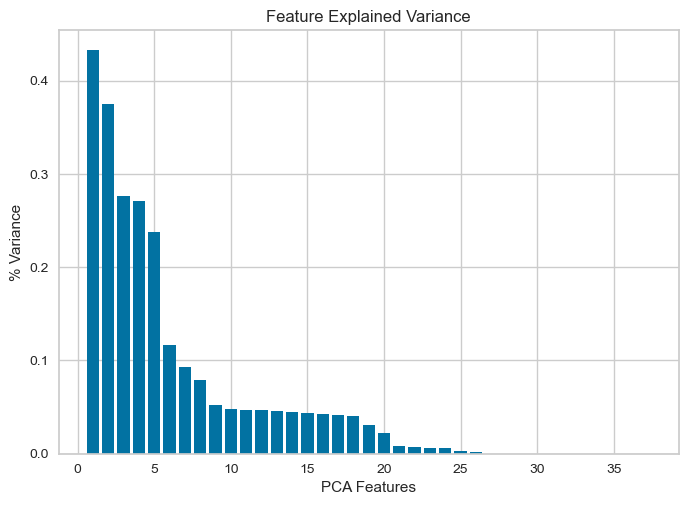

In [185]:
import matplotlib.pyplot as plt
plt.bar(
    range(1,len(pca.explained_variance_ratio_)+1),
    pca.explained_variance_
    )
 
 
plt.xlabel('PCA Features')
plt.ylabel('% Variance')
plt.title('Feature Explained Variance')
plt.show()

This plot shows us that the first 5/6 PCA components retain at least the 70% of the variance.

Let's visualise a more clear plot...

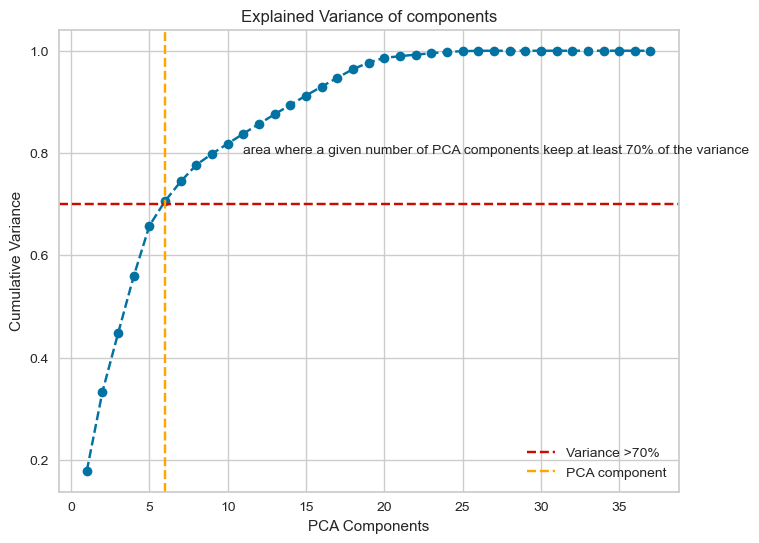

In [198]:
plt.figure(figsize=(8,6))
plt.plot(range(1,38),pca.explained_variance_ratio_.cumsum(),marker='o',linestyle='--')
plt.axhline(y = 0.7, color = 'r', linestyle = '--',label='Variance >70%')
plt.axvline(x = 6, color = 'orange', linestyle = '--',label = 'PCA component')
plt.title('Explained Variance of components')
plt.xlabel('PCA Components')
plt.ylabel('Cumulative Variance')
plt.text(11,0.8,'area where a given number of PCA components keep at least 70% of the variance',fontsize=10)
plt.legend()
plt.show()

This plot shows us how cumulative sum of the variance changes variance changes as components change.<br>
So fixing a number of components at least equal to 6 we preserve at least 70 % of the total variance of this system.

Text(0, 0.5, 'PCA 2')

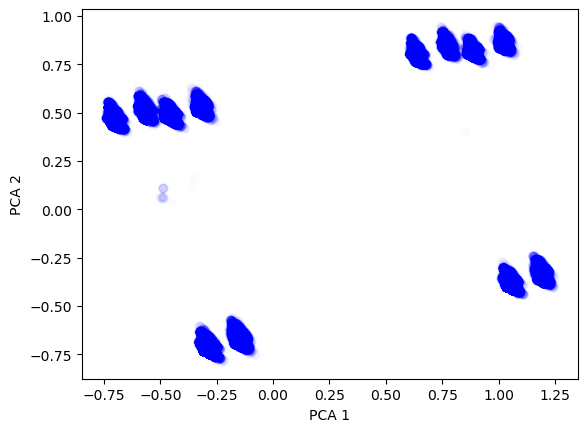

In [126]:
plt.scatter(data.iloc[:,0], data.iloc[:,1], alpha=0.01, color='blue')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

Plotting the scatter plot of the 1st and 2nd PCA componets (those that have the highest percentage of the system variance), it seems that there might be **4 clusters** for these data

In [199]:
pca=PCA(n_components=6) ## reduce dimensionality to 6 components
pca.fit(df_norm)
pca_features=pca.transform(df_norm)

In [200]:
wcss=[]
for i in range(1,22):
    k=KMeans(n_clusters=i,init='k-means++',random_state=40)
    k.fit(pca_features)
    wcss.append(k.inertia_)

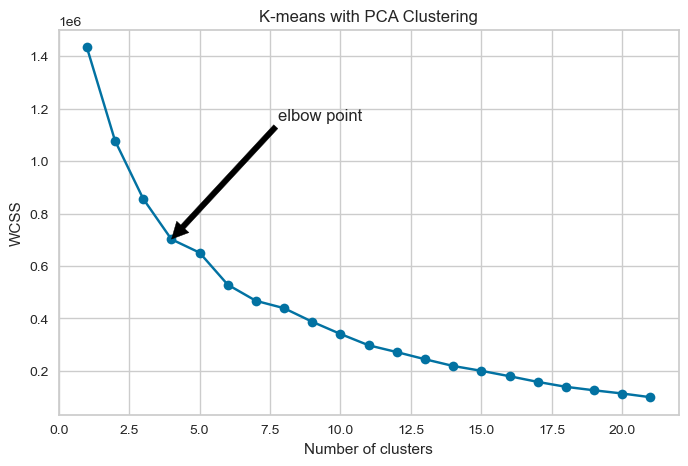

In [201]:
plt.figure(figsize=(8,5))
plt.plot(range(1,22),wcss,marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('K-means with PCA Clustering')
plt.annotate('elbow point',(4,wcss[3]),arrowprops=dict(facecolor='black',shrink=0.001),
            horizontalalignment='left',verticalalignment='top',xytext=(7.8,1200000))
plt.show()

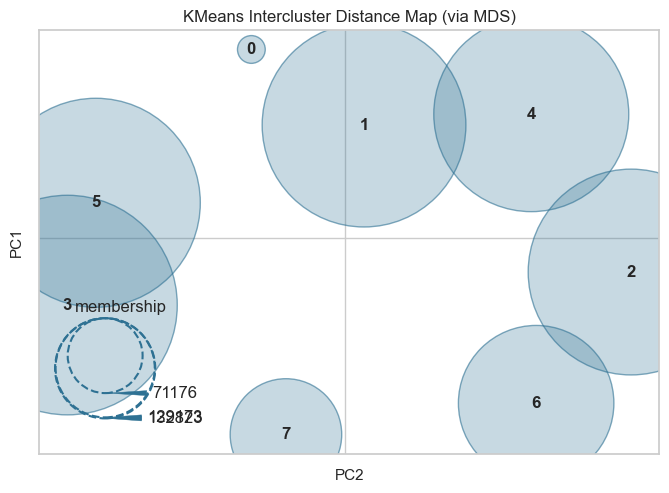

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [202]:
from yellowbrick.cluster import InterclusterDistance


model = KMeans()
visualizer = InterclusterDistance(model)

visualizer.fit(pca_features)        # Fit the data to the visualizer
visualizer.show()       # Finalize and render the figure

In [203]:
k=KMeans(n_clusters=4, init='random',random_state=42)
k=k.fit(pca_features)


In [204]:
df_kmeans=pd.concat([dataset.reset_index(drop=True),pd.DataFrame(pca_features)],axis=1)
df_kmeans['Clusters']=k.labels_

In [465]:
df_kmeans['Segment']=df_kmeans['Clusters'].map({0:'first',1:'second',2:'third',3:'fourth',4:'fifth',5:'sixth',6:'seventh',7:'eighth'})

In [205]:
df_kmeans

,Number_Transactions,Transactions>100,AverageAmountTransactions,AverageBalance,Utilization,MostCommonGender,MostCommonLocation,AverageTransaction(INR),AverageBalance(INR),AverageHourTransaction,...,NumberTransactions>=20h,CustomersAge,NumberUsers,0,1,2,3,4,5,Clusters
0,1,0,0.31,218.18,217.87,F,JAMSHEDPUR,25.0,17819.050,14,...,0,28,1,1.046042,-0.396235,-0.468013,-0.242695,-0.194225,-0.288241,0
1,1,1,342.83,27.80,315.03,M,JHAJJAR,27999.0,2270.690,14,...,0,66,1,-0.724117,0.484737,-0.627980,-0.421151,0.263883,-0.305115,1
2,1,0,5.62,218.86,213.24,F,MUMBAI,459.0,17874.440,14,...,0,26,1,1.179997,-0.337079,-0.185120,0.532332,0.655713,-0.242578,0
3,2,0,17.99,5324.47,5306.48,F,MUMBAI,1469.2,434849.495,17,...,0,46,2,1.032443,0.857643,0.012406,1.025193,0.115336,-0.290014,0
4,1,0,21.58,82.21,60.63,F,NAVI MUMBAI,1762.5,6714.430,18,...,0,35,1,1.041359,-0.389164,-0.475131,-0.253789,-0.180777,-0.286609,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839076,1,0,36.73,5.69,31.04,M,PUNE,3000.0,464.870,18,...,0,43,1,-0.729557,0.473270,-0.894406,-0.311910,0.237249,0.700350,1
839077,1,0,18.37,14.85,3.52,M,BANGALORE,1500.0,1212.700,18,...,0,30,1,-0.592729,0.507363,-0.631285,0.425845,1.095327,0.688309,1
839078,1,0,9.78,93.49,83.71,M,NEW DELHI,799.0,7635.190,18,...,0,32,1,-0.307195,-0.726830,-0.595914,0.121254,-0.255642,0.709973,2
839079,1,0,5.63,334.41,328.78,M,NASHIK,460.0,27311.420,18,...,0,31,1,-0.300457,-0.733776,-0.587837,0.135654,-0.270959,0.709125,2


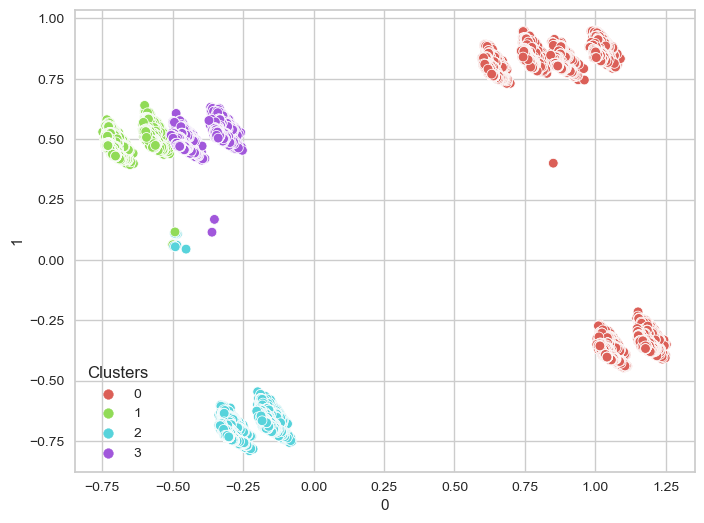

In [206]:
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

x=df_kmeans[0]
y=df_kmeans[1]
plt.figure(figsize=(8,6))
sns.scatterplot(x=x,y=y,hue=df_kmeans['Clusters'],palette=sns.color_palette('hls',4))
plt.show()

In [122]:
import matplotlib.pyplot as plt
import random
from scipy.spatial.distance import cdist

In [ ]:
# init centers
## while not converged
# update clusters membership
# update centers

In [166]:
np.random.seed(111949)
closest,centers = KMEANS(pca_features,4)

In [169]:
df_kmeans['Clusters_Scratch'] = closest
#df_kmeans['ScratchKMeans'] = df_kmeans['ScratchKMeans'].map({0:'first',1:'second',2:'third',3:'fourth'})

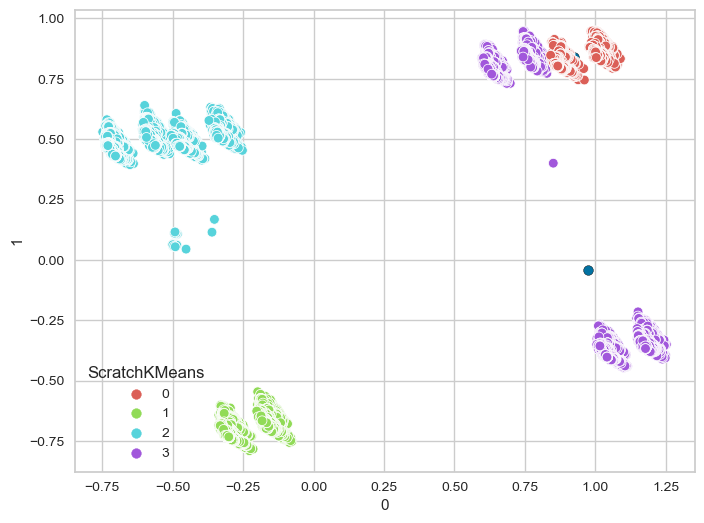

In [170]:
plt.figure(figsize=(8,6))
plt.scatter(centers[:,0],centers[:,1],edgecolors='black')
sns.scatterplot(x=df_kmeans[0],y=df_kmeans[1],hue=df_kmeans['ScratchKMeans'],palette=sns.color_palette('hls',4))

plt.show()

In [151]:
def KMEANS (X_train,k):

    n=X_train.shape[0]
    p=X_train.shape[1]

    min_ = np.min(X_train, axis=0)
    max_ = np.max(X_train,axis=0)
    centers = X_train[np.random.choice(n,k,replace=False)]
    closest = np.zeros(n).astype(int)
    while True:
        prev_closest = closest.copy()
        #print(closest)
        distances=np.sqrt(np.sum(np.abs(X_train.reshape(n,1,p)-centers.reshape(1,k,p))**2,axis=2))
        closest = np.argmin(distances,axis=1)
        for i in range(k):
            centers[i,:] = X_train[closest==i].mean(axis=0)
        if all(closest == prev_closest):
            break
    return closest, centers

In [304]:
df_kmeans.columns

Index([           'Number_Transactions',               'Transactions>100',
            'AverageAmountTransactions',                 'AverageBalance',
                          'Utilization',        'AverageTransaction(INR)',
                  'AverageBalance(INR)',         'AverageHourTransaction',
       'AverageDaysBetweenTransactions',             'Balance_greater_Q3',
                'Balance_between_Q1_Q3',                'Balance_less_Q1',
               'Transaction<10%Balance',         'Transaction>50%Balance',
          'Transaction_less_50%Balance',     'NumberTransactions>Balance',
              'NumberTransactions>=20h',                   'CustomersAge',
                          'NumberUsers',                  'Loc_BANGALORE',
                          'Loc_CHENNAI',                      'Loc_DELHI',
                          'Loc_GURGAON',                  'Loc_HYDERABAD',
                          'Loc_KOLKATA',                     'Loc_MUMBAI',
                        '

In [177]:
table = df_kmeans.drop([0,1,2,3,4,5],axis=1,inplace=False).pivot_table('AverageAmountTransactions',index='Clusters',columns='MostCommonGender')


In [302]:
df_kmeans.drop([0,1,2,3,4,5,6,7],axis=1,inplace=False).loc[df_kmeans.Clusters==0].Gender_F.sum()

0.0

In [178]:
table

MostCommonGender,F,M
Clusters,,
0,19.335259,NaN
1,NaN,10.236058
2,NaN,14.578637
3,NaN,30.379579


In [261]:
table['%OUT_MUMBAI'] =  table[1]/(table[0]+table[1])*100

In [318]:

table[[1,2,3,4,5,6]] = table[[1,2,3,4,5,6]].apply(lambda  x : x/x.sum()*100, axis=1)

In [319]:
table

NumberUsers,1,2,3,4,5,6,Sum
Clusters,,,,,,,
0,15.060700,15.171450,16.264297,20.839279,26.627129,6.037145,112.746449
1,16.241695,15.797499,16.429029,15.935778,19.010037,16.585962,106.204272
2,19.083374,18.021353,17.581947,18.021642,15.978004,11.313680,102.626500
